<a href="https://colab.research.google.com/github/EODAngelo/Data/blob/main/HW6Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6: Deep Learning with CNNs for Star Morphology Analysis

In this final assignment, you will use the same FITS files you explored previously, which contain astronomical images of stars in a specific region of the sky. This time, you will train a convolutional neural network (CNN) to classify stars based on morphological features directly from cropped image patches extracted from the FITS image.

The CNN will be used to:
- Distinguish between point sources (stars), extended sources (galaxies or nebula fragments), and image artifacts (like hot pixels or diffraction spikes).
- Optionally predict star brightness class (dim, moderate, bright) or other physically relevant labels.

### Learning Objectives:

By the end of this assignment, you should be able to:
- Understand how convolutional neural networks extract spatial features from astronomical images.
- Build and train a CNN using TensorFlow.
- Evaluate and visualize model performance on scientific image data.

In [ ]:
# Install required libraries
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch astroquery pytest ipytest

In [ ]:
import ipytest
import pytest
ipytest.autoconfig()

## For pytest to recognize test function it should start with "test_"
% - applies to whole notebook

%% - applies to cell only


In [ ]:
def my_sum(a,b,c):
  return a+b+c

In [ ]:
%%ipytest
# This defines unit test for pytest

def test_my_sum():
  """ This tests the my_sum function for arthmetic correctness """
  assert my_sum(1,2,0) == 3
  assert my_sum(0,0,1) == 1
  assert my_sum(-1,2,-1) == 0

.                                                                                            [100%]
1 passed in 0.01s


In [ ]:
# def test_my_sum_datatype():
# """ This tests the my_sum funciton for arythmetic correctness """
#  with pytest.raises(TypeError):
#  my_sum("a","b","c")

In [ ]:
ipytest.run()

.                                                                                            [100%]
1 passed in 0.01s


<ExitCode.OK: 0>

## Task 1: Data Preparation (8 points)
- Use the same FITS file from Homework 5
- Use astropy to determine the wcs coordinates of the image
- Generate a pandas list os the 10 brightest objects in the image

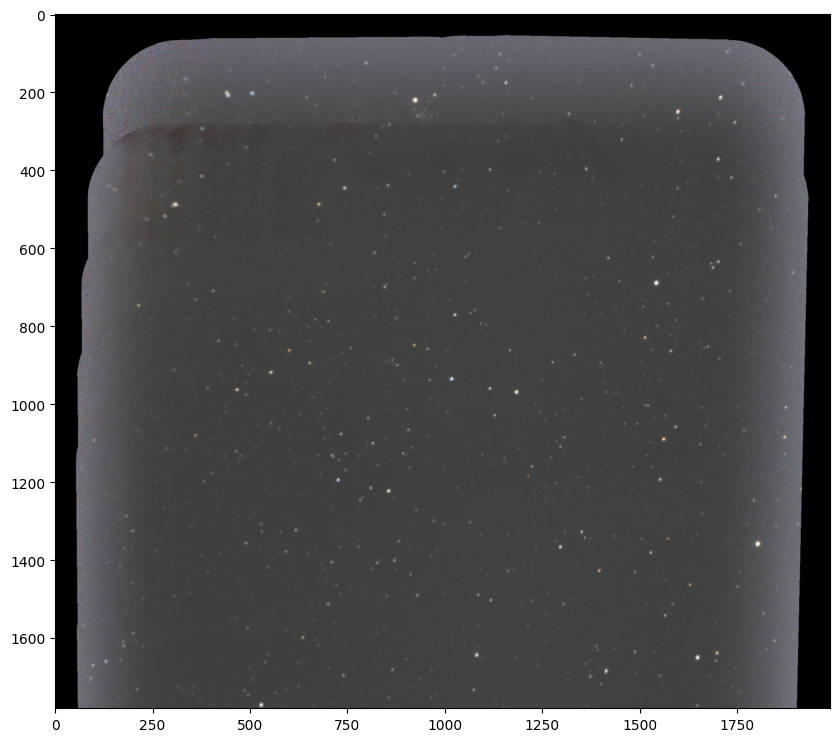

In [ ]:
from astropy.io import fits
from auto_stretch import apply_stretch
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/3low.fits"
response = requests.get(fits_url)
response.raise_for_status()
fits_file = fits.open(BytesIO(response.content))

hdul = fits.open(BytesIO(response.content))
image_data = np.transpose(hdul[0].data, (1,2,0))
red_image = image_data[:,:,0]

#image_data = image_data[400:-400,200:-200,:]
hdul.close()

fig = plt.figure(figsize=(10, 10))
plt.imshow(apply_stretch(image_data))

In [ ]:
import pandas as pd
from astropy.wcs import WCS
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder

bkg_sigma = mad_std(np.mean(image_data, axis=2))

daofind = DAOStarFinder(fwhm=3.0, threshold=bkg_sigma * 10, min_separation = 15)
sources = daofind(np.mean(image_data, axis=2))

catalog = sources.to_pandas().sort_values('flux', ascending=False).head(10)

catalog



id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
170  171  1542.923326   689.091824   0.421826   -0.462434    0.164981    25   
331  332  1803.293359  1358.945596   0.448332   -0.386707    0.133243    25   
81    82   923.748779   219.360233   0.464721   -0.500671    0.015289    25   
374  375  1648.666121  1651.278111   0.411471   -0.239897    0.280038    25   
234  235  1183.809099   969.313074   0.480083   -0.441452    0.111403    25   
91    92  1598.137473   249.223192   0.458131   -0.608191    0.150378    25   
225  226  1017.726779   935.821352   0.401384   -0.387702    0.003738    25   
393  394   528.690065  1772.416738   0.418988   -0.422589    0.137524    25   
264  265  1561.674623  1090.360442   0.470576   -0.388441    0.151394    25   
78    79  1707.822875   212.867241   0.450843   -0.672468    0.090743    25   

             peak           flux        mag  daofind_mag  
170  55435.333333  790753.000000 -14.745102    -5.578493  
331  48755.666667  728219.000000 -14.655655    -5.319174  
81   27249.000000  422838.666667 -14.065437    -4.644884  
374  21071.666667  358756.333333 -13.886999    -4.195393  
234  24129.333333  321049.666667 -13.766431    -4.727653  
91   14875.333333  238559.333333 -13.443991    -3.930267  
225  13581.333333  228899.333333 -13.399111    -3.790386  
393  10627.000000  198655.000000 -13.245249    -3.190724  
264  12601.000000  186834.000000 -13.178640    -3.880904  
78   10504.666667  184977.666667 -13.167798    -3.357227

In [ ]:
wcs = WCS(hdul[0].header, naxis=2)
print(wcs)
sky_coords = wcs.all_pix2world(catalog['xcentroid'],catalog['ycentroid'],1)

catalog['ra'] = sky_coords[0]
catalog['dec'] = sky_coords[1]
catalog

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 25.8111625882977 63.5384206931328 
CRPIX : 995.0 1741.0 
PC1_1 PC1_2  : 0.999778549767352 0.0211508379531688 
PC2_1 PC2_2  : -0.0209811457152273 0.999777631225308 
CDELT : -0.00110883666158442 0.00111216032976206 
NAXIS : 1989  1781  3


id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
170  171  1542.923326   689.091824   0.421826   -0.462434    0.164981    25   
331  332  1803.293359  1358.945596   0.448332   -0.386707    0.133243    25   
81    82   923.748779   219.360233   0.464721   -0.500671    0.015289    25   
374  375  1648.666121  1651.278111   0.411471   -0.239897    0.280038    25   
234  235  1183.809099   969.313074   0.480083   -0.441452    0.111403    25   
91    92  1598.137473   249.223192   0.458131   -0.608191    0.150378    25   
225  226  1017.726779   935.821352   0.401384   -0.387702    0.003738    25   
393  394   528.690065  1772.416738   0.418988   -0.422589    0.137524    25   
264  265  1561.674623  1090.360442   0.470576   -0.388441    0.151394    25   
78    79  1707.822875   212.867241   0.450843   -0.672468    0.090743    25   

             peak           flux        mag  daofind_mag         ra        dec  
170  55435.333333  790753.000000 -14.745102    -5.578493  24.555627  62.350518  
331  48755.666667  728219.000000 -14.655655    -5.319174  23.851600  63.081230  
81   27249.000000  422838.666667 -14.065437    -4.644884  26.054113  61.848428  
374  21071.666667  358756.333333 -13.886999    -4.195393  24.196586  63.414300  
234  24129.333333  321049.666667 -13.766431    -4.727653  25.394648  62.675414  
91   14875.333333  238559.333333 -13.443991    -3.930267  24.468182  61.859550  
225  13581.333333  228899.333333 -13.399111    -3.790386  25.797431  62.642674  
393  10627.000000  198655.000000 -13.245249    -3.190724  26.971335  63.579554  
264  12601.000000  186834.000000 -13.178640    -3.880904  24.470475  62.795406  
78   10504.666667  184977.666667 -13.167798    -3.357227  24.214667  61.813889

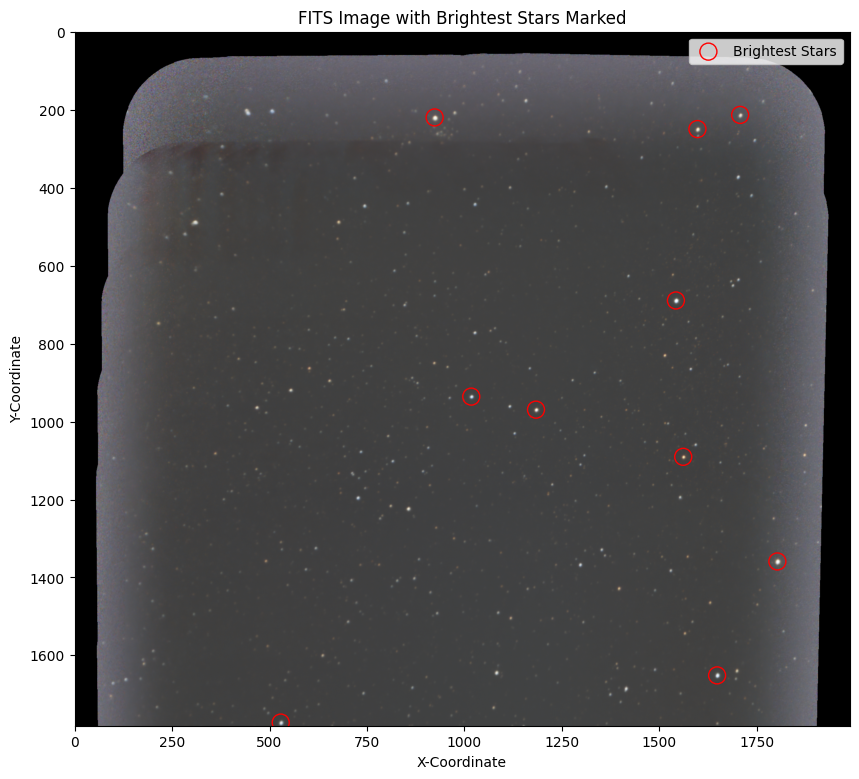

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(apply_stretch(image_data))

plt.scatter(catalog['xcentroid'],catalog['ycentroid'],color='red', marker='o', facecolors='none', s=150, label='Brightest Stars')

plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.title('FITS Image with Brightest Stars Marked')
plt.legend()

plt.show()

## Task 2: Determine the properties of the stars based on a catalog (8 points)
- use the SIMBAD catalog (available through astropy) to determine the following properties of the 10 brightest objects in you image:
    - Name of the object
    - Spectral class
    - object type
    - absolute magnitude (you might have to calculate it)
    - distance to earth

In [ ]:
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import tqdm

options = Simbad.list_votable_fields()


In [ ]:
options[options["type"] == "bundle of basic columns"][["name", "description"]]

<Table length=8>
     name                         description                     
    object                           object                       
------------- ----------------------------------------------------
  coordinates                  all fields related with coordinates
          dim          major and minor axis, angle and inclination
   dimensions              all fields related to object dimensions
    morphtype         all fields related to the morphological type
     parallax                     all fields related to parallaxes
propermotions           all fields related with the proper motions
           sp            all fields related with the spectral type
     velocity all fields related with radial velocity and redshift

In [ ]:
qu = Simbad()
qu.add_votable_fields('basic')
result = qu.query_object('Betelgeuse')
result

<Table length=1>
 main_id          ra               dec        ... rvz_wavelength    matched_id  
                 deg               deg        ...                               
  object       float64           float64      ...      str1           object    
--------- ----------------- ----------------- ... -------------- ---------------
* alf Ori 88.79293899077537 7.407063995272694 ...                NAME Betelgeuse

In [ ]:
Simbad.ROW_LIMIT = 1
Simbad.reset_votable_fields()
Simbad.add_votable_fields("mesdistance", "V", "sp", "otype", "ids")

for idx, row in tqdm(catalog.iterrows(), total=catalog.shape[0]):
  ra, dec = row["ra"], row["dec"]
  coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

  try:
    result = qu.query_region(coord, radius="100s")

    if result:
      catalog.at[idx, "star_name"] = result[0]["main_id"]
      catalog.at[idx, "spectral_type"] = result[0]["sp_type"]
      catalog.at[idx, "object_type"] = result[0]["otype"]
      catalog.at[idx, "visual_mag"] = result[0]["V"]

      dist = result[0]["mesdistance.dist"]
      catalog.at[idx, "Simbad_distance_pc"] = float(dist) if dist is not None else None

  except Exception as e:
    print(f"Error querying Simbad for {idx}: {e}")



 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Error querying Simbad for 170: 'V'


 20%|██        | 2/10 [00:00<00:02,  2.78it/s]

Error querying Simbad for 331: 'V'


 30%|███       | 3/10 [00:01<00:02,  3.12it/s]

Error querying Simbad for 81: 'V'


 40%|████      | 4/10 [00:01<00:01,  3.34it/s]

Error querying Simbad for 374: 'V'


 50%|█████     | 5/10 [00:01<00:01,  3.48it/s]

Error querying Simbad for 234: 'V'


 60%|██████    | 6/10 [00:01<00:01,  3.56it/s]

Error querying Simbad for 91: 'V'


 70%|███████   | 7/10 [00:02<00:00,  3.62it/s]

Error querying Simbad for 225: 'V'


 80%|████████  | 8/10 [00:02<00:00,  3.67it/s]

Error querying Simbad for 393: 'V'


 90%|█████████ | 9/10 [00:02<00:00,  3.71it/s]

Error querying Simbad for 264: 'V'


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]

Error querying Simbad for 78: 'V'


## Task 3: Visualize and label (10 points)
Draw a 64x64 patch of each of the 10 brightest objects and generate a list to label each patch based on:

- Morphology
    - star
    - extended (nebula, galaxy, cluster, ...)
    - artifact (hot pixel, cosmic ray, ...)
    - if you do not have all types, artificially generate one example of each. Use a LLM to have specific shapes suggested. Document if it suggests useful shapes.
- Brightness class
- Spectral class

In [ ]:
import matplotlib.pyplot as plt

def make_patch(image, x, y, size = 64):
  x_min = int(np.clip(x - size/2, 0, image.shape[0]))
  x_max = int(np.clip(x + size/2, 0, image.shape[0]))
  y_min = int(np.clip(y - size/2, 0, image.shape[1]))
  y_max = int(np.clip(y + size/2, 0, image.shape[1]))

  return image[x_min:x_max, y_min:y_max]

plt.imshow(apply_stretch(make_patch(image_data,catalog['xcentroid'][0],catalog['ycentroid'][0])),cmap='gray')

KeyError: 0

## Task 4: Build a CNN (8 points)
- Use TensorFlow/Keras to build a small CNN.
    - Recommended architecture:
    - Conv2D → ReLU → MaxPool
    - Conv2D → ReLU → MaxPool
    - Flatten → Dense → Softmax

You can adapt this depending on whether you are doing binary or multi-class classification.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = 4

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
catalog['spectral_type'].unique()

array(['B7V', '', 'B8III', 'K0.5IIICN1', 'B9V', 'M3Iab'], dtype=object)

## Task 5: Train the Model (10 points)

Now use the top 100 (you can also use more to generate better training data) objects with all information in your image to train your model on the parameters spectral class and absolute magnitude and distance if possible. If you do not have all types genererate 10 examples of each type missing.
Store the resulting pandas dataframe as `catalog.csv` in the same directory as you Jupyter notebook.

Split your dataset into training, validation, and test sets.
- Use categorical crossentropy loss and an appropriate optimizer (e.g., Adam).
- Plot training and validation accuracy/loss curves.

Hint: SIMBAD has a very detailed set of spectral types. Group them according to the main letter (O, B, A, F, G, K, M)

Ask a LLM what final plot you should generate that shows if the CNN works for classification. Generate that plot.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def extract_spectral_class(s):
  """ simplify specral classes, e.g. M1 ---> M """
  if s is np.nan:
    return s
  return s[0]

catalog['simple_spectral_class'] = catalog['spectral_type'].apply(extract_spectral_class)
catalog.head()

IndexError: string index out of range

In [ ]:
le = LabelEncoder()
catalog['spectral_label'] = le.fit_transform(catalog['simple_spectral_class'])
catalog.head()

KeyError: 'simple_spectral_class'

In [ ]:
patches = []
for _, row in catalog.iterrows():
  patch = make_patch(red_image, row['xcentroid'], row['ycentroid'])
  patches.append(patch)
X = np.array(patches)[..., np.newaxis]
y = catalog['spectral_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.